In [1]:
from utils_m1 import *

In [2]:
f = h5py.File('events_2022_02_08_07_36_25_CET.gz.h5', 'r')
data = Data(f)

In [8]:
trackMask = (data.rawTracks['length'] > 100) & (data.rawTracks['nhit'] > 0)
track_idx = np.where(trackMask)[0]
N = len(track_idx)

In [9]:
print(N)

1813


In [1]:
import sys
sys.path.insert(0, '/Users/alex/Desktop/slacube_scratch/slacube/slacube')
# sys.path.insert(0, '/sdf/home/k/kvtsang/sdf/slacube/slacube')

In [568]:
import os
import yaml
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import solarized
import pandas as pd

from glob import glob
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

from slacube.geom import load_layout_np

sns.set_theme(context='talk', style='ticks')

In [3]:
from sklearn.decomposition import PCA

In [681]:
def get_track_distortion(trk, seg):
    coords = np.column_stack([trk['x'], trk['y'], trk['z']])
    dt = trk['dt'] - trk['dt'].min()
    seg_ids = trk['segment_id']
    output = {}
    
    # fit track as a 3D line using first few segments
    mask = np.full(len(trk), False)
    for label in np.argsort(seg['t'])[:2]:
        mask |= seg_ids == label
        
    pca = PCA(1)
    pca.fit(coords[mask])
    
    v_dir = pca.components_[0]
    r0 = coords[mask].mean(axis=0)
    
    output['line_dir'] = v_dir
    output['r0'] = r0
    
    # endpoints of the 3D line
    t0 = (coords[np.argmax(coords[:,2])] - r0).dot(v_dir)
    t1 = (coords[np.argmin(coords[:,2])] - r0).dot(v_dir)
    output['endpts'] = np.stack([r0 + t0 * v_dir, r0 + t1 * v_dir])
    
    # "true" track
    t_par = (coords - r0).dot(v_dir)
    pred = r0 + t_par[:,None] * v_dir[None,:]
    output['reco'] = coords
    output['true'] = pred
    
    # fit v_drift
    z_pred = pred[:,2]
    nbins = 15
    bins = np.linspace(0, 300, nbins+1)
    bins[-1] = 500
    groups = np.digitize(z_pred, bins)
    output['v_drift'] = np.zeros(nbins)
    output['v_drift_err'] = np.zeros(nbins)
    
    for g in range(1, nbins+1):
        mask = groups == g
        if np.count_nonzero(mask) < 5:
            continue
            
        v, mcov = curve_fit(
            lambda t, v : v*t*0.1, dt[mask], z_pred[mask], p0=[1.]
        )
        
        output['v_drift'][g-1]= v[0]
        output['v_drift_err'][g-1] = np.sqrt(mcov[0,0])

            
    return output

In [852]:
files = glob('/scratch/k/kvtsang/slacube/trk_5kV/*.h5')
#files = files[:2]

In [853]:
len(files)

148

In [854]:
output = []

for fpath in tqdm(files):
    with h5py.File(fpath, 'r') as f:
        summary = f['summary'][:]
        
        mask = summary['theta'] < 0.99
        #mask &= summary['dz'] > 300
        mask &= summary['dt'] > 3750
        
        if not np.any(mask):
            continue
        
        tracks = f['tracks']
        segments = f['segments']
        tracks_toc = np.insert(summary['track_size'].cumsum(), 0, [0])
        segments_toc = np.insert(summary['segment_size'].cumsum(), 0, [0])
        
        selections = np.where(mask)[0]
        
        for i_trk in selections:            
            trk = tracks[slice(*tracks_toc[i_trk:i_trk+2])]
            seg = segments[slice(*segments_toc[i_trk:i_trk+2])]
            
            output.append(get_track_distortion(trk, seg))

  0%|          | 0/148 [00:00<?, ?it/s]

In [630]:
concat = lambda key : np.concatenate([out[key] for out in output])
stack = lambda key : np.stack([out[key] for out in output])

In [855]:
reco_coords = concat('reco')
true_coords = concat('true')
v_drift = stack('v_drift')
v_drift_err = stack('v_drift_err')

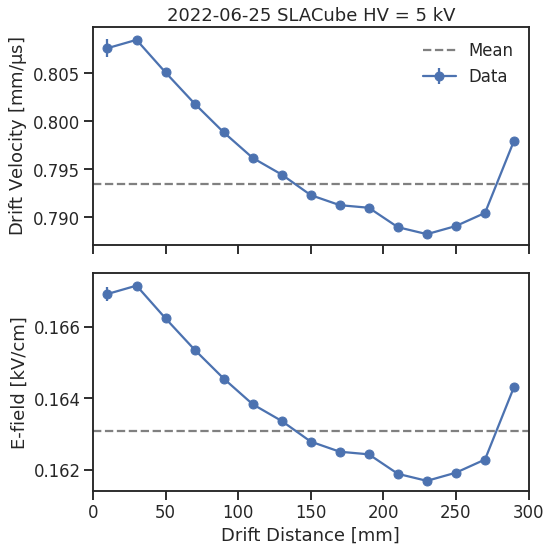

In [856]:
nbins = v_drift.shape[1]

v_fit = np.zeros(nbins)
v_err = np.zeros_like(v_fit)
bins = np.linspace(0, 300, nbins+1)
z_fit = (bins[1:] + bins[:-1]) / 2

mean_vdrift = v_drift[v_drift > 0].mean()


for i in range(nbins):
    mask = v_drift[:,i] > 0
    #if np.count_nonzero(mask) == 0:
    #    continue
    v_fit[i] = np.median(v_drift[mask, i])
    #v_err[i] = v_drift[mask, i].std() / np.count_nonzero(mask)
    
    var = np.sum(v_drift_err[mask, i]**2)
    v_err[i] = np.sqrt(var) / np.count_nonzero(mask)

fig, axes = plt.subplots(2,1,figsize=(8, 8),sharex=True)
ax = axes[0]
ax.errorbar(z_fit, v_fit, yerr=v_err, fmt='o-', label='Data')
ax.hlines(mean_vdrift, 0, 300, color='grey', linestyle='--', label='Mean')
ax.set_title('2022-06-25 SLACube HV = 5 kV')
ax.set_ylabel('Drift Velocity [$\mathrm{mm/\mu s}$]')
ax.set_xlim(0, 300)
ax.legend(frameon=False)

df = pd.read_csv('vdrift_efield.csv')
e_field = np.interp(v_fit, df.v_drift*10., df.e_field)
mean_efield = np.interp(mean_vdrift, df.v_drift*10., df.e_field)


ax = axes[1]
ax.errorbar(z_fit, e_field, v_err/v_fit*e_field, fmt='o-')
ax.hlines(mean_efield, 0, 300, color='grey', linestyle='--')

#ax.scatter(z_fit, e_field, 'o-')

ax.set_xlabel('Drift Distance [mm]')
ax.set_ylabel('E-field [kV/cm]')

fig.align_ylabels()
fig.tight_layout()

In [857]:
mean_efield

0.16309758315656456

In [859]:
mean_efield * 300

48.929274946969365

In [860]:
e_field.min() / mean_efield - 1

-0.008608415268815062

In [861]:
x, y, z = reco_coords.T
dx, dy, dz = (reco_coords - true_coords).T

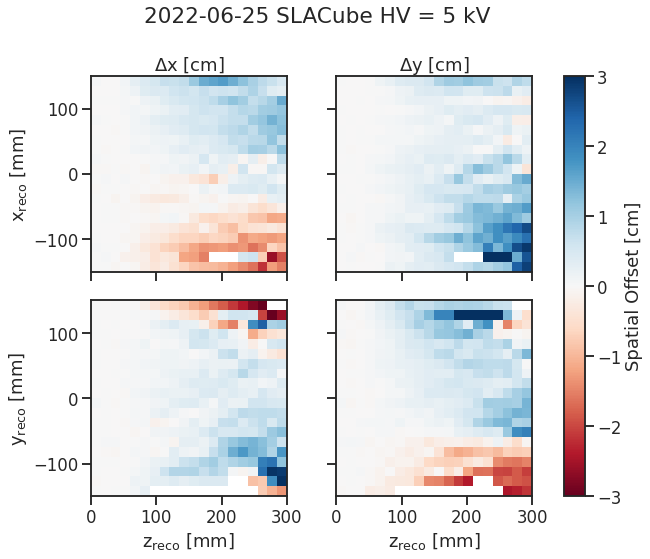

In [862]:
fig, axes = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)

vmax = 3
bins = 20
kwargs = dict(
    vmin=-vmax, vmax=vmax,
    cmap='RdBu',
    origin='lower',
    extent=[0,300,-150,150],
    interpolation='none',
)
    

ax = axes[0,0]
pf = binned_statistic_2d(z, x, dx/10., bins=bins, range=[(0,300), (-150,150)])
ax.imshow(pf.statistic.T, **kwargs)
ax.set_ylabel('$\mathrm{x_{reco}}$ [mm]')
ax.set_title('$\mathrm{\Delta x}$ [cm]')

ax = axes[0,1]
pf = binned_statistic_2d(z, x, dy/10., bins=bins, range=[(0,300), (-150,150)])
ax.imshow(pf.statistic.T, **kwargs)
ax.set_title('$\mathrm{\Delta y}$ [cm]')

ax = axes[1,0]
pf = binned_statistic_2d(z, y, dx/10., bins=bins, range=[(0,300), (-150,150)])
ax.imshow(pf.statistic.T, **kwargs)
ax.set_ylabel('$\mathrm{y_{reco}}$ [mm]')
ax.set_xlabel('$\mathrm{z_{reco}}$ [mm]')

ax = axes[1,1]
pf = binned_statistic_2d(z, y, dy/10., bins=bins, range=[(0,300), (-150,150)])
im = ax.imshow(pf.statistic.T, **kwargs)
ax.set_xlabel('$\mathrm{z_{reco}}$ [mm]')

fig.suptitle('2022-06-25 SLACube HV = 5 kV')
fig.tight_layout()


#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)

cax,kw = mpl.colorbar.make_axes(axes.flatten())
plt.colorbar(im, cax=cax, label='Spatial Offset [cm]')

Text(0.5, 0, 'z [mm]')

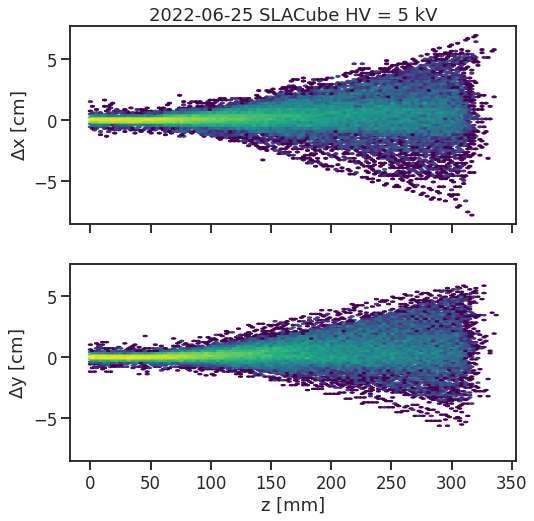

In [850]:
fig, axes = plt.subplots(2,1,figsize=(8, 8),sharex=True,sharey=True)

ax = axes[0]
ax.hexbin(z, dx/10, mincnt=1, cmap='viridis', bins='log')
ax.set_ylabel('$\mathrm{\Delta x}$ [cm]')
ax.set_title('2022-06-25 SLACube HV = 5 kV')


ax = axes[1]
ax.hexbin(z, dy/10, mincnt=1, cmap='viridis', bins='log')
ax.set_ylabel('$\mathrm{\Delta y}$ [cm]')
ax.set_xlabel('z [mm]')

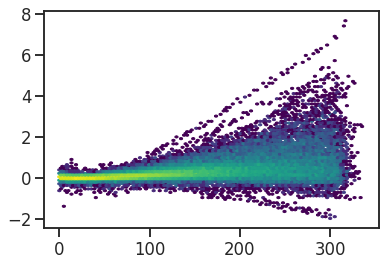

In [819]:
plt.hexbin(z, dz/10, mincnt=1, cmap='viridis', bins='log')

In [825]:
pf = binned_statistic_2d(z, x, dx/10., bins=[5,20], range=[(0,300), (-150,150)])


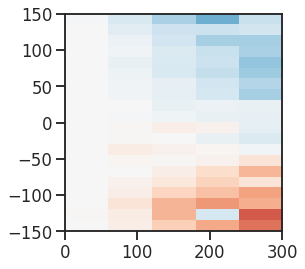

In [827]:
plt.imshow(pf.statistic.T, **kwargs)


In [824]:
pf.statistic.shape

(10, 20)

Text(0.5, 1.0, 'At 87.68 K')

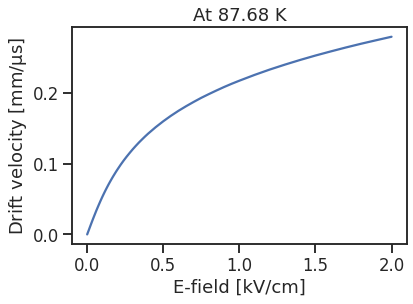

In [841]:
fig = plt.figure(figsize=(6,4))
plt.plot(df.e_field, df.v_drift)
plt.xlabel('E-field [kV/cm]')
plt.ylabel('Drift velocity [$\mathrm{mm/\mu s}$]')
plt.title('At 87.68 K')